# Convolutional Neural Networks - Age Prediction

## Preparations

In [2]:
import os

## adapt this directories to your needs
base_dir = '../../'
data_dir_base = "D:/Users/Julian/OneDrive - FH OOe/Kurse/3. Semester/NDLeIL/Datasets"
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(data_dir_base, 'age-prediction/20-50')

In [3]:
import os, shutil
import random
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from pyMLaux import show_img_data, plot_history, evaluate_regression_result

In [4]:
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

## Configure Data Sources

In [5]:
batch_size = 64
img_size = (128, 128)

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    validation_split=0.15,
    subset='training',
    seed = 4232,
    image_size=img_size,
    batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    validation_split=0.15,
    subset='validation',
    seed=4232,
    image_size=img_size,
    batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle=False,
    image_size=img_size,
    batch_size=batch_size)

Found 33432 files belonging to 31 classes.
Using 28418 files for training.
Found 33432 files belonging to 31 classes.
Using 5014 files for validation.
Found 7008 files belonging to 31 classes.


In [7]:
train_data.class_names

['20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50']

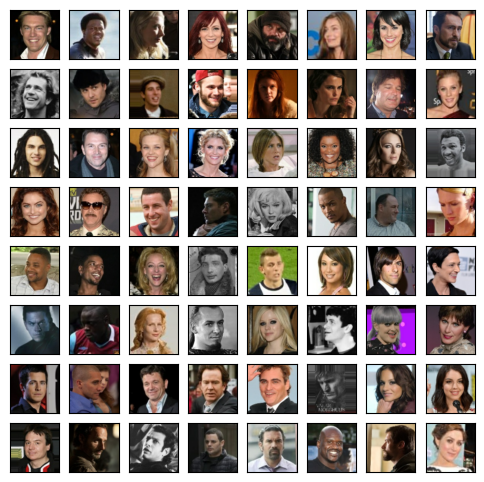

In [8]:
for image_batch, label_batch in train_data:
    show_img_data(image_batch / 255., no=batch_size, layout=(8, 8), figsize=(6, 6))
    break

## Create Model
### Modified compared to model 2:
* Replaced Flatten with GlobalAveragePooling2D
* Increased dense layer complexity (256->128->1 instead of 32->1)
* Use Adam optimizer with lr=1e-4
* Added additional dropout layer and increased rates
* Added RandomBrightness and RandomContrast to augmentation

In [9]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.02, fill_mode='constant', fill_value=-1.),
    tf.keras.layers.RandomZoom(0.1, fill_mode='constant', fill_value=-1.),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
], name='data_augmentation')

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1.),
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(96, (3, 3), padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(96, (3, 3), padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=None),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mae'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 96)     │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 96)     │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 96)     │             

 Total params: 264,545 (1.01 MB)

 Trainable params: 263,009 (1.00 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Train Model

In [ ]:
filepath = os.path.join(base_dir, 'Models/age-prediction_model3/age-prediction3_{epoch:02d}-{val_mae:.4f}.keras')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1,
                                                save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(train_data, epochs=50, validation_data=validation_data,
                    callbacks=callbacks_list)

Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 238.0556 - mae: 12.8466
Epoch 1: val_mae improved from inf to 7.65374, saving model to ../../Models/age-prediction_model2/age-prediction2_01-7.6537.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - loss: 237.9382 - mae: 12.8428 - val_loss: 84.2739 - val_mae: 7.6537
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 95.5842 - mae: 8.0844
Epoch 2: val_mae improved from 7.65374 to 7.29902, saving model to ../../Models/age-prediction_model2/age-prediction2_02-7.2990.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 888s 2s/step - loss: 95.5751 - mae: 8.0841 - val_loss: 75.0008 - val_mae: 7.2990
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 86.1854 - mae: 7.7395
Epoch 3: val_mae improved from 7.29902 to 7.21157, saving model to ../../Models/age-prediction_model2/age-prediction2_03-7.2116.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 882s 2s/step - loss: 86.1843 - mae: 7.7395 - val_loss: 73.8236 - val_mae: 7.2116
Epoch 4/50
445/445 ━━━━━━

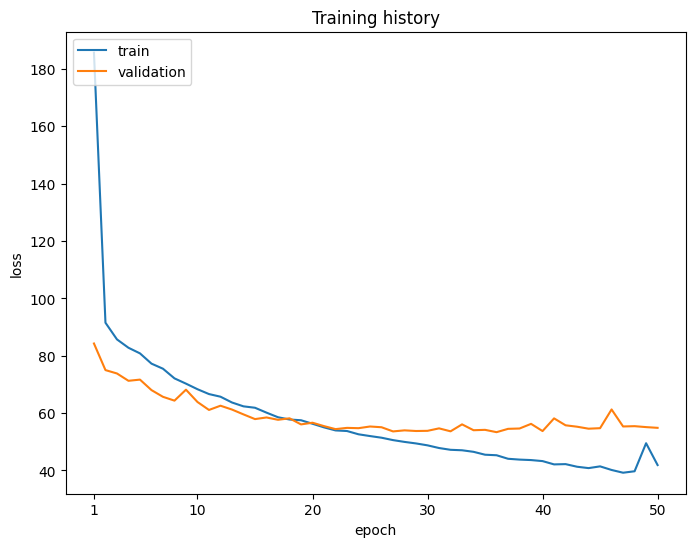

In [25]:
plot_history(history)

## Evaluate on Test Data

In [26]:
pred = model.predict(test_data)

110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step


In [27]:
test_y = np.concatenate([labels for _, labels in test_data], axis=0)

In [28]:
evaluate_regression_result(test_y + 20., pred + 20.) # Add  20.0 to make sure we add the correct offset

Target feature 0:
    Mean squared error (MSE):           58.149
    Root mean squared error (RMSE):      7.626
    Mean absolute error (MAE):           6.168
    Coefficient of determination (R2):   0.282
    Correlation coefficient (Pearson):   0.546 (p = 0.00e+00)


## Evaluate on Test Data (best model)

In [29]:
# Load the best model
model = tf.keras.models.load_model(r"../../Models\age-prediction_model2\age-prediction2_36-5.9294.keras")

In [30]:
pred = model.predict(test_data)

110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 548ms/step


In [31]:
evaluate_regression_result(test_y + 20., pred + 20.) # Add  20.0 to make sure we add the correct offset 

Target feature 0:
    Mean squared error (MSE):           55.537
    Root mean squared error (RMSE):      7.452
    Mean absolute error (MAE):           6.051
    Coefficient of determination (R2):   0.314
    Correlation coefficient (Pearson):   0.566 (p = 0.00e+00)


In [ ]:
!jupyter nbconvert --to html Ex4_Grimm_Model3.ipynb

[NbConvertApp] Converting notebook Ex4_Grimm_Model2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 840214 bytes to Ex4_Grimm_Model2.html
